In [10]:
import numpy as np
import sys
import os
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [11]:
sys.path.append(os.path.abspath('C:/Users/vpming/tuni_ml/src'))
from extract_data import build_features_100samples_df, extract_noise

In [12]:
data_path = 'C:/Users/vpming/tuni_ml/data'
all_df = build_features_100samples_df(data_path)

In [13]:
min_count = all_df['dis_to_target'].value_counts().min()

n_samples = min_count

# Balance the df
df = (
    all_df.groupby('dis_to_target', group_keys=False)
    .apply(lambda x: x.sample(n=n_samples, random_state=42))
    .reset_index(drop=True)
)

print(df['dis_to_target'].value_counts())

dis_to_target
0    20000
1    20000
2    20000
3    20000
Name: count, dtype: int64


C:\Users\vpming\AppData\Local\Temp\ipykernel_9936\1389712327.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=n_samples, random_state=42))


In [14]:
df['noise'] = df['simulation_file'].apply(extract_noise)

In [15]:
x = df[['cMax', 'cVariance']].values

y = df['dis_to_target'].values

# 4 classes: 0, 1, 2, 3
n_bins = 4
bins = np.linspace(y.min(), y.max(), n_bins + 1)
y_class = np.digitize(y, bins[1:-1])  # produces class labels 0,1,2,3

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.2, random_state=42)

# Scale only the input features
x_scaler = StandardScaler()
x_train_s = x_scaler.fit_transform(x_train)
x_test_s = x_scaler.transform(x_test)

train_ds = TensorDataset(torch.tensor(x_train_s, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(x_test_s, dtype=torch.float32),
                        torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

In [16]:
class MLP(nn.Module):
    def __init__(self, n_timepoints, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_timepoints, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )
    def forward(self, x):
        return self.net(x)

In [17]:
def evaluate(model, data_loader, loss_fn):
    model.eval()
    total, correct, running_loss = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    avg_loss = running_loss / total
    acc = 100 * correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return avg_loss, acc, all_preds, all_labels

In [20]:
def fit(model, train_loader, test_loader, epochs=50):
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        avg_loss = running_loss / total
        acc = 100 * correct / total
        train_losses.append(avg_loss)
        train_accs.append(acc)

        # Evaluate on test
        test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, loss_fn)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs} Train Loss: {avg_loss:.4f}  Train Accuracy: {acc:.2f}%  Test Loss: {test_loss:.4f}  Test Accuracy: {test_acc:.2f}%')
        
    torch.save({
        'model_state_dict': model.state_dict()
    }, "C:/Users/vpming/tuni_ml/src/model/balanced_mlp_dtt.pt")

    # Plot losses and accuracies
    epochs_range = np.arange(1, epochs+1)
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_accs, label='Train Acc')
    plt.plot(epochs_range, test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curve')

    # Confusion matrix for final test predictions
    plt.subplot(1, 3, 3)
    conf_mat = confusion_matrix(test_labels, test_preds)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

    return train_losses, test_losses, train_accs, test_accs, conf_mat

Epoch 5/50 Train Loss: 1.1834  Train Accuracy: 40.62%  Test Loss: 1.1848  Test Accuracy: 40.73%
Epoch 10/50 Train Loss: 1.1776  Train Accuracy: 40.84%  Test Loss: 1.1749  Test Accuracy: 40.86%
Epoch 15/50 Train Loss: 1.1750  Train Accuracy: 41.10%  Test Loss: 1.1731  Test Accuracy: 41.13%
Epoch 20/50 Train Loss: 1.1743  Train Accuracy: 40.96%  Test Loss: 1.1731  Test Accuracy: 41.01%
Epoch 25/50 Train Loss: 1.1731  Train Accuracy: 41.33%  Test Loss: 1.1818  Test Accuracy: 40.17%
Epoch 30/50 Train Loss: 1.1719  Train Accuracy: 41.18%  Test Loss: 1.1696  Test Accuracy: 41.36%
Epoch 35/50 Train Loss: 1.1715  Train Accuracy: 41.14%  Test Loss: 1.1683  Test Accuracy: 41.27%
Epoch 40/50 Train Loss: 1.1704  Train Accuracy: 41.27%  Test Loss: 1.1737  Test Accuracy: 40.93%
Epoch 45/50 Train Loss: 1.1694  Train Accuracy: 41.44%  Test Loss: 1.1699  Test Accuracy: 41.58%
Epoch 50/50 Train Loss: 1.1700  Train Accuracy: 41.34%  Test Loss: 1.1686  Test Accuracy: 41.71%


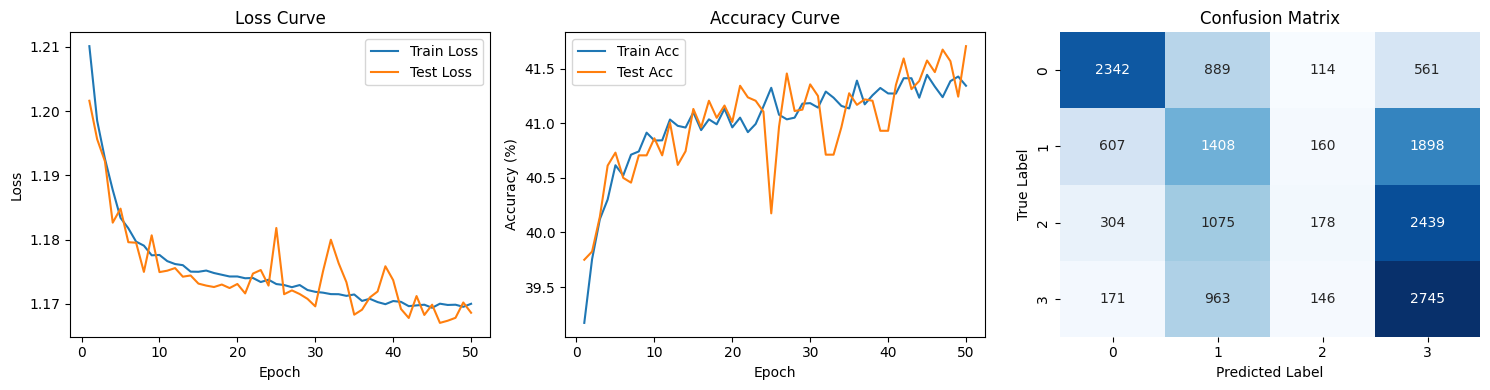

([1.2101119952201844,
  1.1985125634670257,
  1.192573664009571,
  1.1877302124500275,
  1.1833843656778336,
  1.1817653634548186,
  1.1796786693930625,
  1.1790587984919547,
  1.177554326891899,
  1.1776091138720512,
  1.1766491883397103,
  1.1761955734491347,
  1.1760181231498719,
  1.175010288834572,
  1.174988703608513,
  1.1751795682311057,
  1.1747962910532952,
  1.174525593996048,
  1.1742561533451081,
  1.1742587496042252,
  1.1739815423488618,
  1.1740246251225472,
  1.1733940238952636,
  1.1737517861127853,
  1.1730797488093376,
  1.1729246539473535,
  1.172589787364006,
  1.1729236192703247,
  1.1721498718261718,
  1.1718688494563103,
  1.1717363625764847,
  1.1715118148326873,
  1.171498014986515,
  1.17124105489254,
  1.1714571264982223,
  1.1704545198082923,
  1.1707852550148965,
  1.1702731660604477,
  1.1699432680010795,
  1.1704324172735214,
  1.1703075628876687,
  1.1696350271105767,
  1.1697564437389374,
  1.1698625027537346,
  1.1693835782408715,
  1.170022188663482

In [21]:
# Define model
n_timepoints = x_train.shape[1]
n_classes = len(np.unique(y_train))
model = MLP(n_timepoints, n_classes)

fit(model, train_loader, test_loader)


=== Training for noise 0.01 ===
Training on 12844 samples; Testing on 3211 samples
Epoch 5/15 Train Loss: 0.7032  Train Accuracy: 65.76%  Test Loss: 0.7761  Test Accuracy: 62.88%
Epoch 10/15 Train Loss: 0.6156  Train Accuracy: 71.23%  Test Loss: 0.8068  Test Accuracy: 61.63%
Epoch 15/15 Train Loss: 0.5270  Train Accuracy: 76.56%  Test Loss: 0.8625  Test Accuracy: 61.69%


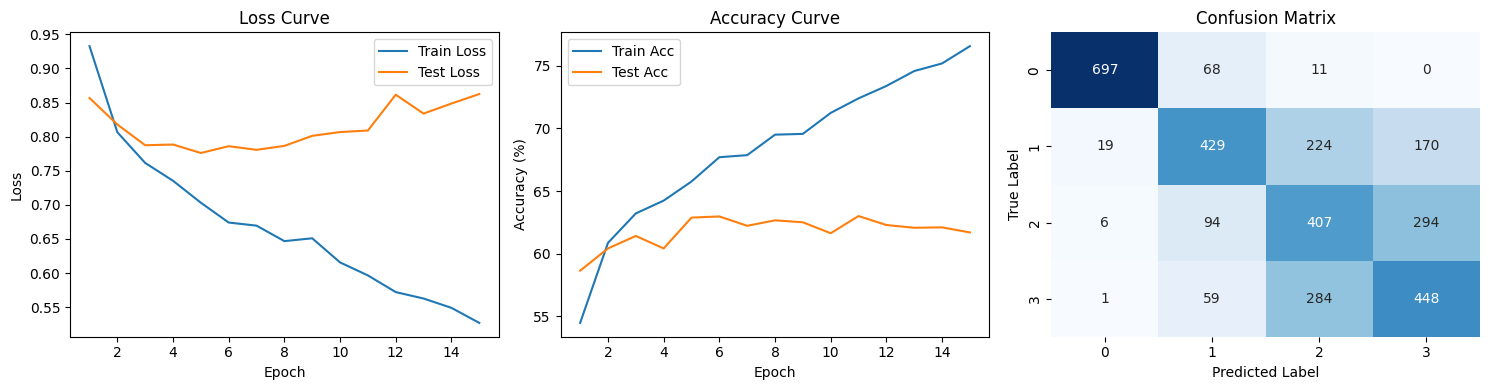


=== Training for noise 0.02 ===
Training on 12929 samples; Testing on 3233 samples
Epoch 5/15 Train Loss: 0.7733  Train Accuracy: 63.32%  Test Loss: 0.8656  Test Accuracy: 57.53%
Epoch 10/15 Train Loss: 0.6585  Train Accuracy: 69.46%  Test Loss: 0.9514  Test Accuracy: 56.05%
Epoch 15/15 Train Loss: 0.5521  Train Accuracy: 76.02%  Test Loss: 1.1122  Test Accuracy: 55.68%


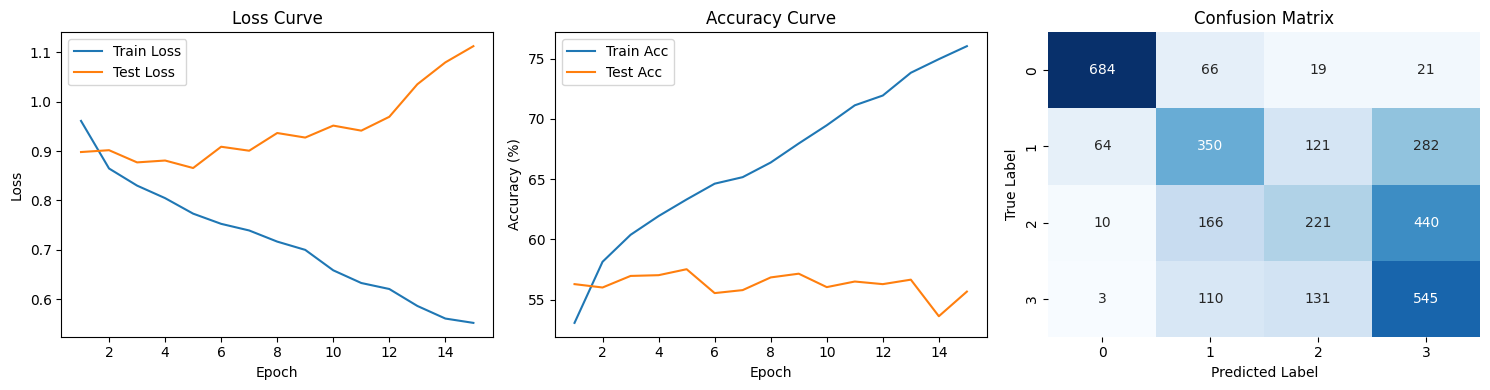


=== Training for noise 0.03 ===
Training on 12798 samples; Testing on 3200 samples
Epoch 5/15 Train Loss: 0.8620  Train Accuracy: 59.37%  Test Loss: 0.9404  Test Accuracy: 54.62%
Epoch 10/15 Train Loss: 0.7204  Train Accuracy: 67.87%  Test Loss: 1.0219  Test Accuracy: 53.66%
Epoch 15/15 Train Loss: 0.5570  Train Accuracy: 76.53%  Test Loss: 1.1783  Test Accuracy: 52.59%


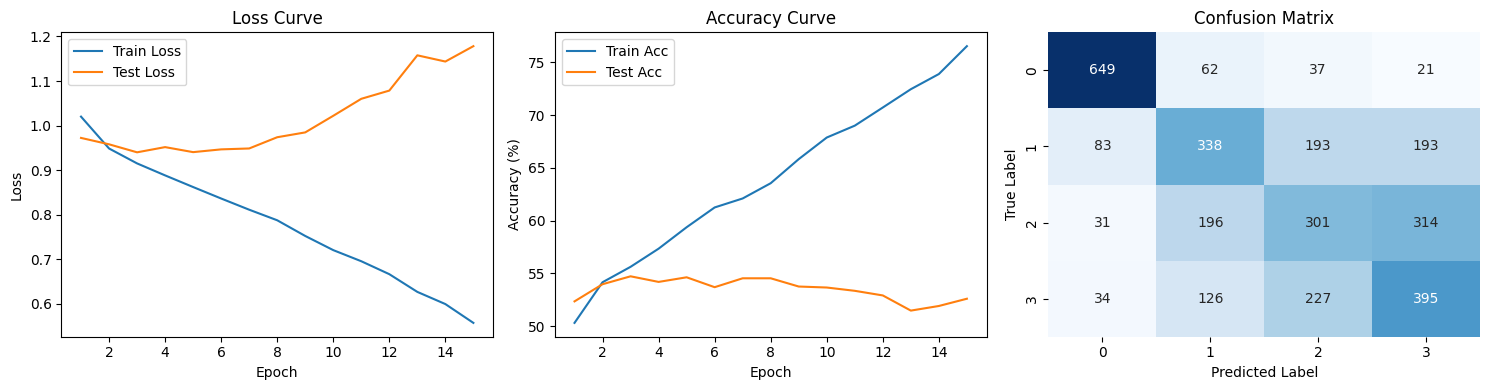


=== Training for noise 0.04 ===
Training on 12640 samples; Testing on 3160 samples
Epoch 5/15 Train Loss: 0.9453  Train Accuracy: 56.52%  Test Loss: 1.0700  Test Accuracy: 49.65%
Epoch 10/15 Train Loss: 0.7868  Train Accuracy: 65.24%  Test Loss: 1.1911  Test Accuracy: 47.82%
Epoch 15/15 Train Loss: 0.6042  Train Accuracy: 75.38%  Test Loss: 1.4391  Test Accuracy: 46.11%


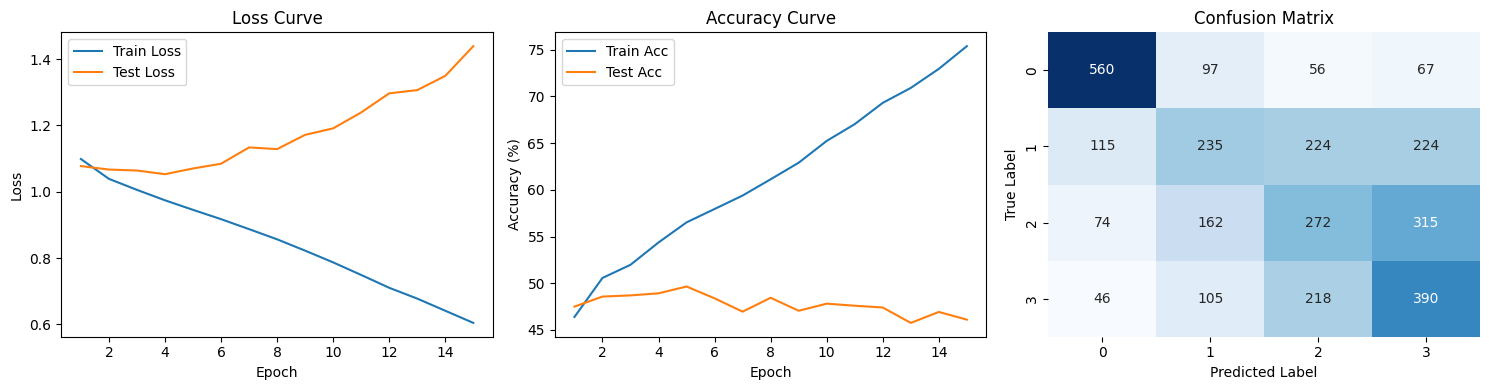


=== Training for noise 0.05 ===
Training on 12788 samples; Testing on 3197 samples
Epoch 5/15 Train Loss: 1.0087  Train Accuracy: 53.62%  Test Loss: 1.1313  Test Accuracy: 45.92%
Epoch 10/15 Train Loss: 0.8503  Train Accuracy: 62.74%  Test Loss: 1.2545  Test Accuracy: 44.85%
Epoch 15/15 Train Loss: 0.6658  Train Accuracy: 72.22%  Test Loss: 1.5041  Test Accuracy: 44.20%


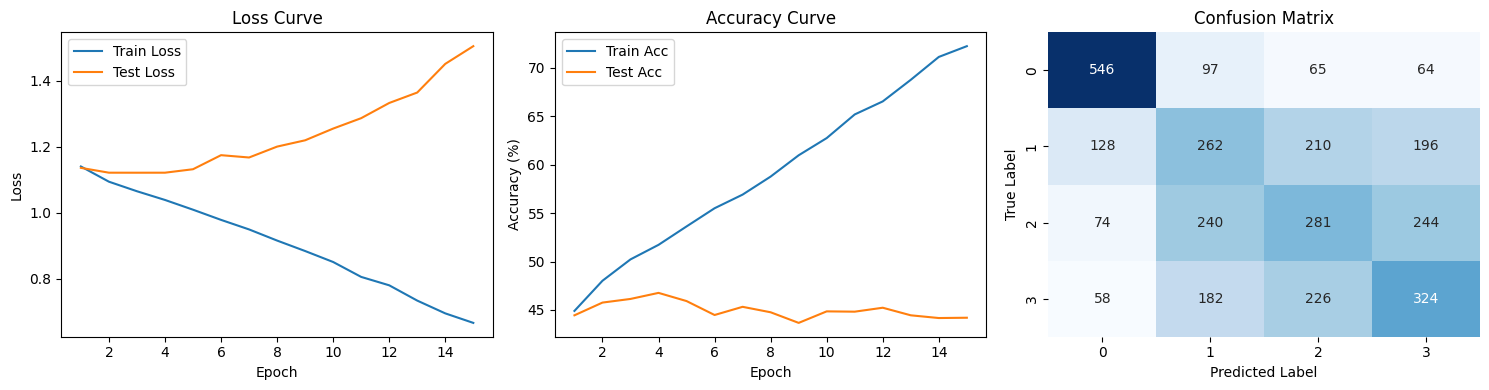

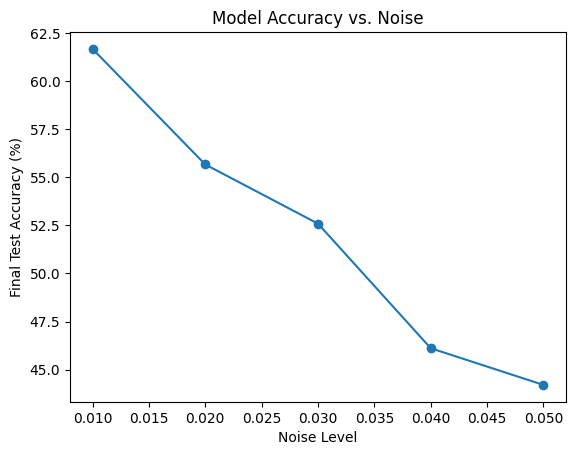

In [22]:
df['noise'] = df['simulation_file'].apply(extract_noise)

results = []

for noise_level in sorted(df['noise'].unique()):
    print(f'\n=== Training for noise {noise_level} ===')
    mask = df['noise'] == noise_level
    X = np.stack(df.loc[mask, 'time_trace'])
    y = df.loc[mask, 'dis_to_target'].values  

    n_bins = 4
    bins = np.linspace(y.min(), y.max(), n_bins + 1)
    y_class = np.digitize(y, bins[1:-1])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    train_ds = TensorDataset(torch.tensor(X_train_s, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.long))
    test_ds = TensorDataset(torch.tensor(X_test_s, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long))
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64)

    # Define model for this run
    n_timepoints = X_train.shape[1]
    n_classes = len(np.unique(y_train))
    model = MLP(n_timepoints, n_classes)

    # Train & evaluate (use your fit function)
    print(f"Training on {X_train.shape[0]} samples; Testing on {X_test.shape[0]} samples")
    train_losses, test_losses, train_accs, test_accs, conf_mat = fit(model, train_loader, test_loader, epochs=15)
    results.append({'noise': noise_level, 'test_acc': test_accs[-1], 'confusion_matrix': conf_mat})

# Plot performance vs. noise
plt.plot([r['noise'] for r in results], [r['test_acc'] for r in results], marker='o')
plt.xlabel("Noise Level")
plt.ylabel("Final Test Accuracy (%)")
plt.title("Model Accuracy vs. Noise")
plt.show()